# edit_webmap.py

Tweeks a web map which has been generated by **qgis2web** and stored in **index.html**.
Output is saved in **new_index.html**.

In [1]:
#from docopt import docopt
import re
import spatialite
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt

In [2]:
INDEXPATH = '/home/aubrey/Desktop/Guam06-CRB-Damage-Map/webmap/index.html'
DATABASEPATH = '/home/aubrey/Desktop/Guam06-CRB-Damage-Map/Guam06.db'
ABSTRACT_SUBTITLE_1 = 'Guam Roadside Imagery Survey'
ABSTRACT_SUBTITLE_2 = 'February 2022'
ABSTRACT_DATASOURCE = 'https://github.com/aubreymoore/Guam06-CRB-Damage-Map'

a
{'videos_count': '1', 'tracks_count': '1', 'tracks_total_meters': '563398.709029233', 'frames_count': '23842', 'frames_min_time': '2022-02-15 01:22:20', 'frames_max_time': '2022-02-23 03:09:25', 'trees_count': '8656', 'trees_damage_0': '8027', 'trees_damage_1': '184', 'trees_damage_2': '77', 'trees_damage_3': '326', 'trees_damage_4': '42', 'trees_damage_mean': '0.171441774491682', 'trees_damaged': '629', 'vcuts_count': '290'}
b


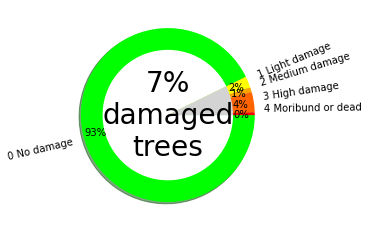

In [3]:
def bake_pie(stats):

    data = {'0 No damage':        stats['trees_damage_0'],
            '1 Light damage':     stats['trees_damage_1'],
            '2 Medium damage':    stats['trees_damage_2'],
            '3 High damage':      stats['trees_damage_3'],
            '4 Moribund or dead': stats['trees_damage_4']
            }
    colors = ['#00ff00', '#ffff00', '#ffa500', '#ff6400', '#ff0000']

    data1 = {'not damaged': int(stats['trees_count'])-int(stats['trees_damaged']),
             'damaged': int(stats['trees_damaged'])}
    colors1 = ['white', 'lightgrey']

    fig, ax = plt.subplots()

    ax.pie(x=list(data.values()),
            colors=colors,
            labels=data.keys(),
            autopct='%1.0f%%',
            pctdistance=0.85,
            counterclock=False,
            rotatelabels=True,
            shadow=True
            )
    ax.pie(x=list(data1.values()),
            colors=colors1,
            radius=0.75,
            counterclock=False,
            rotatelabels=True
            )
    percent_damaged = 100*data1['damaged']/(data1['damaged']+data1['not damaged'])
    plt.text(0,0,f'{percent_damaged:.0f}%\ndamaged\ntrees', horizontalalignment='center', verticalalignment='center',
             fontsize=28)
    ax.set(aspect="equal")
    #plt.savefig('pie.svg')
    plt.savefig(INDEXPATH.replace('index.html','pie.svg'))


# Query DB for stats

conn = spatialite.connect(DATABASEPATH)
df = pd.read_sql('SELECT * FROM stats;', conn)
stats = dict(zip(df.name, df.val))
conn.close()
print('a')
print(stats)
print('b')

bake_pie(stats)

# Add project abstract
abstract =  '<b>Coconut Rhinoceros Beetle Damage</b><br>'
abstract += f'<b>{ABSTRACT_SUBTITLE_1}</b><br>'
abstract += f'<b>{ABSTRACT_SUBTITLE_2}</b><br><br>'
abstract += '<table>'
abstract += f'<tr><td>Start date:</td><td  style="text-align:right">{stats["frames_min_time"][:10]}</td></tr>'
abstract += f'<tr><td>End date:</td><td  style="text-align:right">{stats["frames_max_time"][:10]}</td></tr>'
abstract += f'<tr><td>Images examined:</td><td style="text-align:right">{int(stats["frames_count"]):,}</td></tr>'
abstract += '<tr></tr>'
abstract += f'<tr><td><b>V-cuts detected:</b></td><td style="text-align:right"><b>{int(stats["vcuts_count"]):,}</b></td></tr>'
abstract += '<tr></tr>'
abstract += f'<tr><td><b>Coconut palm images:</b></td><td style="text-align:right"><b>{int(stats["trees_count"]):,}</b></td></tr>'
abstract += f'<tr><td>0 No damage:</td><td style="text-align:right">{int(stats["trees_damage_0"]):,}</td></tr>'
abstract += f'<tr><td>1 Light damage:</td><td style="text-align:right">{int(stats["trees_damage_1"]):,}</td></tr>'
abstract += f'<tr><td>2 Medium damage:</td><td style="text-align:right">{int(stats["trees_damage_2"]):,}</td></tr>'
abstract += f'<tr><td>3 High damage:</td><td style="text-align:right">{int(stats["trees_damage_3"]):,}</td></tr>'
abstract += f'<tr><td>4 Moribund or dead:</td><td style="text-align:right">{int(stats["trees_damage_4"]):,}</td></tr>'
abstract += f'<tr><td><b>Mean damage index:</td><td style="text-align:right"><b>{float(stats["trees_damage_mean"]):.3f}</b></td></tr>'
percent_trees_damaged = 100 * (1 - int(stats["trees_damage_0"])/int(stats["trees_count"]))
abstract += f'<tr><td><b>Trees damaged:</td><td style="text-align:right"><b>{percent_trees_damaged:.1f}%</b></td></tr>'
abstract += '</table>'
abstract += '<img src="pie.svg" width="350">'
abstract += '<br>Repository:'
abstract += f'<br><a href="{ABSTRACT_DATASOURCE}">{ABSTRACT_DATASOURCE}</a>'

# Load string with file contents
with open(INDEXPATH, 'r') as f:
    s = f.read()

# Change fillOpacity for mean_damage_index symbology
s = re.sub(r"(feature\.properties\['mean_damage_index'\][\S\s]*?)(fillOpacity: 1)", r'\1fillOpacity: 0.75', s)

# Change width of the abstract box
s = re.sub(r"(\<style\>)", r"\1\n.abstractUncollapsed {max-width: 100%;}", s)

# Change abstract text
s = re.sub(r"(div.classList.add\(\"abstractUncollapsed\"\);\s+this._div.innerHTML = ')(.*)(';)", f'\\1{abstract}\\3', s)

# Disable hiding abstract: comment 2 lines and change another
s = re.sub(r"(this._div.setAttribute)", r'//\1', s)
s = re.sub(r"this.hide", r'this.show', s)

# write changes to new_abstract.html
filepath = INDEXPATH.replace('index', 'new_index')
with open(filepath, 'w') as f:
    f.write(s)